In [1]:
import tensorflow as tf
import os 
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

2025-03-15 04:43:17.424690: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-15 04:43:17.552956: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742028197.713071   36401 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742028197.758147   36401 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742028197.926535   36401 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
gpu

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

In [3]:
data_dir = 'data' 
image_exts = ['jpeg','jpg', 'bmp', 'png']
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            #os.remove(image_path)



In [4]:
data = tf.keras.utils.image_dataset_from_directory('data')


Found 457 files belonging to 2 classes.


I0000 00:00:1742028208.671099   36401 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [5]:
data_iterator = data.as_numpy_iterator()


In [6]:
batch = data_iterator.next()


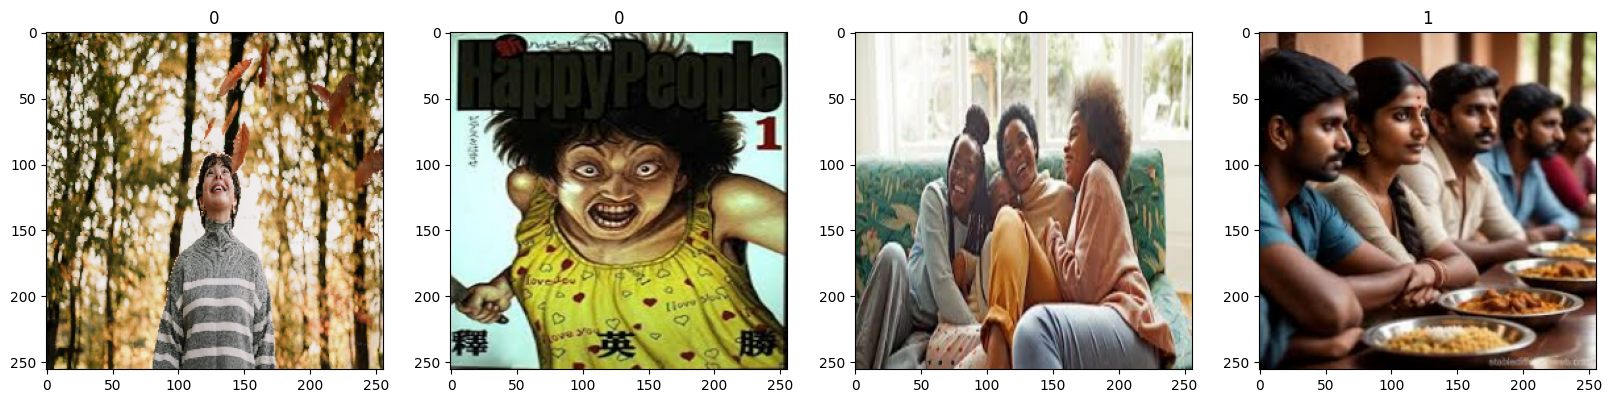

In [7]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [8]:
data = data.map(lambda x,y: (x/255, y))


In [9]:
data.as_numpy_iterator().next()


(array([[[[0.7764706 , 0.8156863 , 0.8235294 ],
          [0.6994485 , 0.7386642 , 0.74650735],
          [0.67961854, 0.7188343 , 0.7266774 ],
          ...,
          [0.67008275, 0.6975337 , 0.72653186],
          [0.74188876, 0.76933974, 0.79286915],
          [0.74509805, 0.77254903, 0.79607844]],
 
         [[0.73154104, 0.7707567 , 0.77859986],
          [0.6440137 , 0.6832294 , 0.6910725 ],
          [0.61513895, 0.65435463, 0.66219777],
          ...,
          [0.7199013 , 0.7473523 , 0.7763505 ],
          [0.7296347 , 0.7570857 , 0.7806151 ],
          [0.7354703 , 0.7629213 , 0.7864507 ]],
 
         [[0.6450061 , 0.6842218 , 0.69206494],
          [0.6133273 , 0.652543  , 0.66038615],
          [0.6220507 , 0.6612664 , 0.6691095 ],
          ...,
          [0.7380833 , 0.7655343 , 0.7945324 ],
          [0.7318922 , 0.7593432 , 0.7828726 ],
          [0.7114583 , 0.7389093 , 0.7624387 ]],
 
         ...,
 
         [[0.6642923 , 0.6995864 , 0.7270374 ],
          [0.65242

In [10]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [11]:
train_size

10

In [12]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [13]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [15]:
model = Sequential()


In [16]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))

/home/somya/Image Classifier/my_tf_env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [18]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,882 (14.10 MB)

 Trainable params: 3,696,882 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
logsdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logsdir)

In [20]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


I0000 00:00:1742028213.804976   36507 service.cc:152] XLA service 0x7f0470208110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742028213.805859   36507 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-03-15 04:43:34.710911: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742028215.019968   36507 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-15 04:43:35.726075: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_324', 4 bytes spill stores, 4 bytes spill loads



 1/10 ━━━━━━━━━━━━━━━━━━━━ 1:18 9s/step - accuracy: 0.4375 - loss: 0.7190

I0000 00:00:1742028220.986591   36507 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 254ms/step - accuracy: 0.4726 - loss: 3.6841 - val_accuracy: 0.5104 - val_loss: 0.6864
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5276 - loss: 0.6894

2025-03-15 04:43:44.499668: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.5313 - loss: 0.6894 - val_accuracy: 0.5833 - val_loss: 0.6838
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.5580 - loss: 0.6823 - val_accuracy: 0.7083 - val_loss: 0.6519
Epoch 4/20


2025-03-15 04:43:45.813547: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.6645 - loss: 0.6510 - val_accuracy: 0.6771 - val_loss: 0.6111
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.6922 - loss: 0.6036 - val_accuracy: 0.7812 - val_loss: 0.5236
Epoch 6/20
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8750 - loss: 0.4805

2025-03-15 04:43:48.179141: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.7828 - loss: 0.5250 - val_accuracy: 0.7083 - val_loss: 0.5527
Epoch 7/20
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7500 - loss: 0.5457

2025-03-15 04:43:49.339101: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.7768 - loss: 0.4810 - val_accuracy: 0.8646 - val_loss: 0.3690
Epoch 8/20


2025-03-15 04:43:50.348892: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.8300 - loss: 0.3949 - val_accuracy: 0.9271 - val_loss: 0.3095
Epoch 9/20


2025-03-15 04:43:51.347094: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.9040 - loss: 0.3126 - val_accuracy: 0.8125 - val_loss: 0.3331
Epoch 10/20
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9375 - loss: 0.2478

2025-03-15 04:43:52.552465: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9026 - loss: 0.2633 - val_accuracy: 0.9688 - val_loss: 0.1812
Epoch 11/20
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9688 - loss: 0.1583

2025-03-15 04:43:53.668690: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9356 - loss: 0.2096 - val_accuracy: 0.9479 - val_loss: 0.2001
Epoch 12/20
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.9375 - loss: 0.2020

2025-03-15 04:43:54.797085: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9362 - loss: 0.2059 - val_accuracy: 0.9896 - val_loss: 0.1395
Epoch 13/20


2025-03-15 04:43:55.951921: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9473 - loss: 0.1703 - val_accuracy: 0.9688 - val_loss: 0.1321
Epoch 14/20
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9688 - loss: 0.1221

2025-03-15 04:43:57.027045: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9532 - loss: 0.1506 - val_accuracy: 0.8021 - val_loss: 0.4362
Epoch 15/20
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9062 - loss: 0.2040

2025-03-15 04:43:58.180528: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.9351 - loss: 0.2097 - val_accuracy: 0.9688 - val_loss: 0.1220
Epoch 16/20


2025-03-15 04:43:59.225340: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9635 - loss: 0.1338 - val_accuracy: 0.9896 - val_loss: 0.0861
Epoch 17/20
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9688 - loss: 0.0674

2025-03-15 04:44:00.431976: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9733 - loss: 0.0986 - val_accuracy: 1.0000 - val_loss: 0.0354
Epoch 18/20
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 0.0544

2025-03-15 04:44:01.500398: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9948 - loss: 0.0618 - val_accuracy: 0.9792 - val_loss: 0.0519
Epoch 19/20


2025-03-15 04:44:02.614605: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9955 - loss: 0.0351 - val_accuracy: 1.0000 - val_loss: 0.0145
Epoch 20/20
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 0.0107

2025-03-15 04:44:03.749834: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.9877 - loss: 0.0453 - val_accuracy: 1.0000 - val_loss: 0.0118


2025-03-15 04:44:04.773200: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


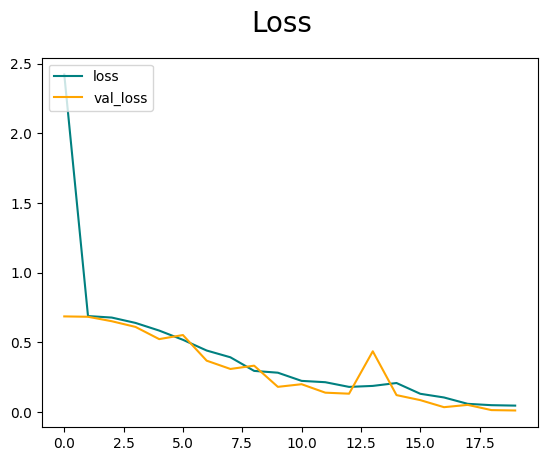

In [21]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

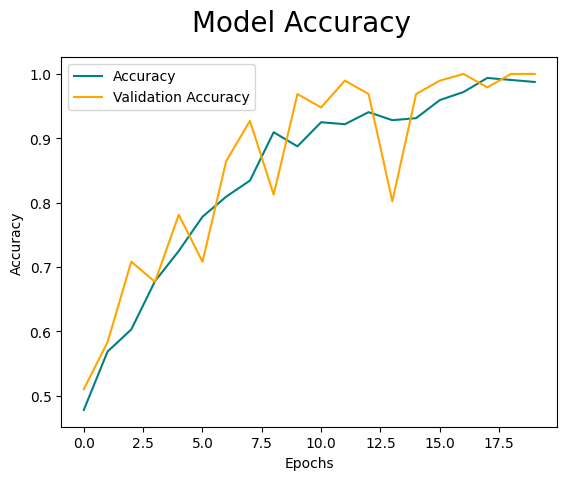

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='Accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
fig.suptitle('Model Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()


In [23]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy


In [ ]:

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X) 
    yhat_labels = np.argmax(yhat, axis=1) 

    pre.update_state(y, yhat_labels)
    re.update_state(y, yhat_labels)
    acc.update_state(y, yhat_labels)

print(f'Precision: {pre.result().numpy()}')
print(f'Recall: {re.result().numpy()}')
print(f'Accuracy: {acc.result().numpy()}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Precision: 1.0
Recall: 1.0
Accuracy: 1.0


2025-03-15 04:45:17.285935: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


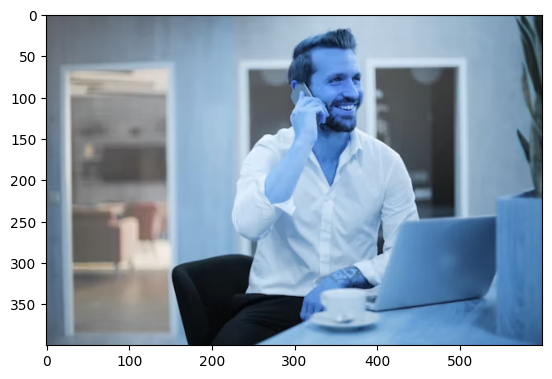

In [26]:
img = cv2.imread('test_image.png')
plt.imshow(img)
plt.show()

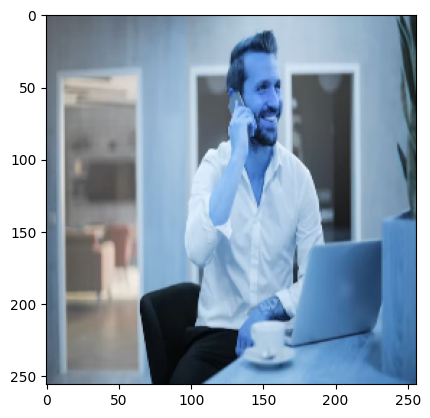

In [27]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [34]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


array([[0.96409166, 0.03590829]], dtype=float32)

In [ ]:
yhat_label = np.argmax(yhat)  

if yhat_label == 1:
    print("Predicted class is Sad")
else:
    print("Predicted class is Happy")


Predicted class is Happy


Found 457 files belonging to 2 classes.


Class names: ['Happy Images', 'Sad Images']
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


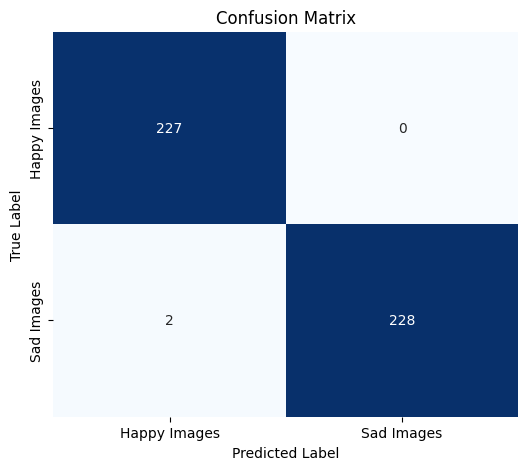

In [41]:
# Confusion Matrix for Model Predictions

import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

dataset_path = "data/"
batch_size = 32
img_size = (255, 255)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

class_names = test_dataset.class_names
print("Class names:", class_names)

test_dataset = test_dataset.map(lambda x, y: (x/255, y))

model = tf.keras.models.load_model("/home/somya/Image Classifier/models/imageclassifier.h5")

y_true = np.concatenate([y.numpy() for _, y in test_dataset])

y_pred_probs = model.predict(test_dataset)

if y_pred_probs.shape[1] == 1:
    y_pred = (y_pred_probs > 0.5).astype(int)
else:
    y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
